In [1]:
#= Vamos assumir uma tubulação com distancia 100 e diametro 5

                                    Distancia entre os transdutores
                     |----------------------------------------------------|
                     .                                                    .
                     .                                                    .
                     .                                                    .            
                     .                                                    .                                                    
                     .                        100                         .
|--------------------T-----------------------------------------------------------------------------------|
| -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> ->> |
| -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> ->> | 5
| -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> -> ->> |
|-------------------------------------------------------------------------T------------------------------|

Dessa forma é possivel distribuir os transdutores no espaço entre 0 e 100 pontos da tubulção.

vamos assumir que cada ponto dos 100 é igual a 1cm, logo temos uma tubulação de 1 metro.

Dentro dessa tubulação está passando um fluido, no caso deste exemplo, agua.

Neste exemplo iremos assumir que o fluido varia de forma linear, e iremos calcular o fluxo em cada passo baseado nas funções acima.

Nota: Neste exemplo será ignorado alguns fatores de fluidos, como a questão de fluxo laminar, gradiente de pressão, e perfil de velocidade parabolico




A ideia principal é:

* Criar uma lista de velocidades linear
    [0.1,0.2,0.3,...,9.9,10.0]
* Criar uma lista de distancia entre os transdutores (Nesse caso será feito uma progressão linear da distancia)
    [0.1,0.2,0.3....99.9,100.00]
* Calcular o Angulo e a distancia real percorrida pela onda

                                     |----------|
                                     | Calcular |
  [Distancia entre transdutor]  ---> |  Angulo  |  ---> [Alpha, Distancia_L]
                                     |----------|

* Calcular o tempo que a onda ultrassonica leva para percorrer a Distancia_L


                                         |----------|
                                         | Calcular |
  [Alpha, Distancia_L, Velocidade]  ---> |  Tempo   |  ---> [Tempo_subida, Tempo_Descida]
                                         |----------|

* Aplicar ruidos de leitura nos dados de tempo

* Calcular a velocidade baseada nos tempos de subida e descida


                                                          |----------|
                                                          | Calcular |
  [Alpha, Distancia_L, Tempo_subida, Tempo_descida]  ---> |  Tempo   |  ---> [Velocidade]
                                                          |----------|

* Plotar grafico de velocidade real x velocidade calculada

* Calcular e plotar curva de erro

* Criar tabela relacionando distancia entre transdutores e valor calculado

=#




In [2]:
function calc_angle(transduct_dis::Float64,diameter::Float64)
    theta_rad::Float64 = atan(diameter/transduct_dis)
    theta_degree::Float64 = rad2deg(theta_rad)
    L_dis::Float64 = sqrt(transduct_dis^2+diameter^2)
    
    return [theta_degree,L_dis]
end

calc_angle (generic function with 1 method)

In [3]:
function calc_time(angle::Float64,L_dis::Float64,vel::Float64)
    c::Float64 = 1480.00
    time_down = L_dis/(c+vel*cosd(angle))
    time_up = L_dis/(c-vel*cosd(angle))
    return [time_up,time_down,vel,angle,L_dis]
end

calc_time (generic function with 1 method)

In [4]:
function calc_velocity(angle::Float64,L_dis::Float64,tu::Float64,td::Float64)
    delta_time = tu-td
    v::Float64 = (L_dis * delta_time)/(2*cosd(angle)*tu*td)
    return v
end

calc_velocity (generic function with 1 method)

In [5]:
using Plots
import Pkg; Pkg.add("DataFrames")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [6]:
velocitys = range(0.1,10.0,100)
distance_btw_transductores = range(0,100,100)

0.0:1.0101010101010102:100.0

In [7]:
angle_L_dis = []
for i in distance_btw_transductores
    push!(angle_L_dis,calc_angle(i,5.0))
end

print(length(angle_L_dis))

100

In [8]:
times = []
for iter in velocitys
    for (a,b) in angle_L_dis
        push!(times,calc_time(a,b,iter))
    end
end

print(length(times))

10000

In [9]:
velocity_measured = []
for (tu,td,vel,angle,l) in times
    #print(vel)
    push!(velocity_measured,calc_velocity(angle,l,tu,td))
end

print(length(velocity_measured))


10000

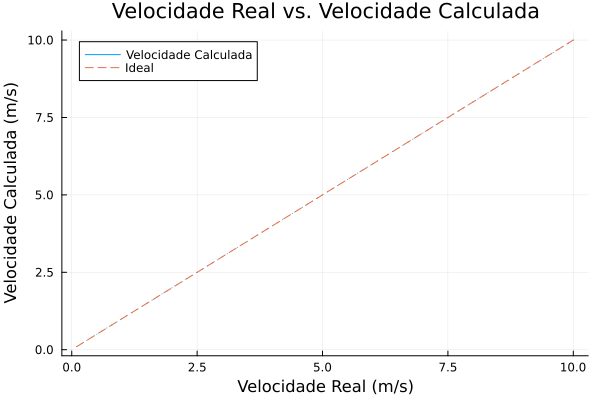

In [12]:

vel_real = [vel for (tu, td, vel, angle, l) in times]
vel_calc = velocity_measured

# Plotar a velocidade real vs. velocidade calculada
plot(vel_real, vel_calc, xlabel="Velocidade Real (m/s)", ylabel="Velocidade Calculada (m/s)", title="Velocidade Real vs. Velocidade Calculada", label="Velocidade Calculada", legend=:topleft)
plot!(x -> x, label="Ideal", linestyle=:dash) # Linha ideal y=x



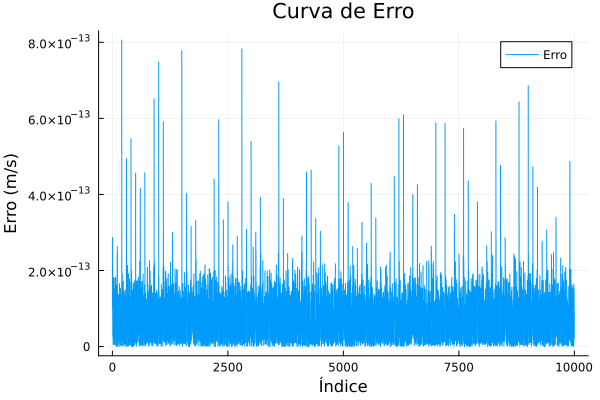

In [13]:
# Calculando o erro
erro = [abs(vel_real[i] - vel_calc[i]) for i in 1:length(vel_real)]

# Plotar a curva de erro
plot(1:length(erro), erro, xlabel="Índice", ylabel="Erro (m/s)", title="Curva de Erro", label="Erro", legend=:topright)



In [15]:
# Criar uma tabela relacionando a distância entre transdutores e o valor calculado
using DataFrames

dist_transdutores = [d for d in distance_btw_transductores for i in 1:length(velocitys)]
tabela = DataFrame(Distância_cm=dist_transdutores, Velocidade_Real=vel_real, Velocidade_Calculada=vel_calc, Erro=erro)

println(tabela)
display_dataframe_to_user("Tabela de Velocidades", tabela)

10000×4 DataFrame
   Row │ Distância_cm  Velocidade_Real  Velocidade_Calculada  Erro          
       │ Float64       Float64          Any                   Float64       
───────┼────────────────────────────────────────────────────────────────────
     1 │      0.0                  0.1  NaN                   NaN
     2 │      0.0                  0.1  0.1                     2.22419e-13
     3 │      0.0                  0.1  0.1                     9.94899e-14
     4 │      0.0                  0.1  0.1                     2.87062e-13
     5 │      0.0                  0.1  0.1                     2.34882e-13
     6 │      0.0                  0.1  0.1                     1.82562e-13
     7 │      0.0                  0.1  0.1                     7.61058e-14
     8 │      0.0                  0.1  0.1                     1.38584e-13
     9 │      0.0                  0.1  0.1                     2.86715e-14
    10 │      0.0                  0.1  0.1                     5.92165e-14
 

Excessive output truncated after 524288 bytes.

LoadError: UndefVarError: `display_dataframe_to_user` not defined